# Bitcoin Trading Environment: Trading vs. Buy and Hold

Dieses Notebook simuliert ein Bitcoin Trading Environment, bei dem das Portfolio als Multiplikator startet (Startwert = 1.0).  
Es wird der Vergleich zwischen einer Trading-Strategie (zufällige Aktionen) und einer Buy-and-Hold-Strategie in einem Diagramm dargestellt.  
Die y-Achse im Vergleichsplot wird logarithmisch skaliert.


In [41]:
%matplotlib inline

import gym
import numpy as np
import yfinance as yf
from gym import spaces
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


## Environment-Definition

Die Klasse `BitcoinTradingEnv` simuliert den Bitcoin-Handel.  
- **Portfolio:** Startet als Multiplikator bei 1.0 (z. B. 1.2 bedeutet +20% Gewinn, 0.8 bedeutet -20% Verlust).  
- **Aktionen:**  
  - 0 = Halten  
  - 1 = Kaufen (nur, wenn nicht investiert)  
  - 2 = Verkaufen (nur, wenn investiert)  
- Die `step()`-Methode aktualisiert den Portfolio-Multiplikator basierend auf der prozentualen Preisänderung.  
- Mit `plot_comparison_log()` wird der Verlauf des Trading-Portfolios mit einer Buy-and-Hold-Strategie (ab Start investiert) in einem logarithmisch skalierten Diagramm verglichen.


In [42]:
class BitcoinTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, window_size=30, initial_capital=1.0, 
                 start_date='2014-09-17', end_date='2025-01-28'):
        super(BitcoinTradingEnv, self).__init__()
        self.window_size = window_size
        self.initial_capital = initial_capital  # Portfolio startet bei 1
        
        # Bitcoin-Daten laden
        self.df = yf.download('BTC-USD', start=start_date, end=end_date)
        self.df.columns = self.df.columns.get_level_values(0)
        self.data = self.df[['Close', 'High', 'Low', 'Open', 'Volume']].copy()
        self.num_features = self.data.shape[1]
        
        # Skaliere Features in [0, 1]
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.scaled_features = self.scaler.fit_transform(self.data.values)
        self.close_prices = self.df['Close'].values
        
        # Aktionsraum: 0 = Halten, 1 = Kaufen, 2 = Verkaufen
        self.action_space = spaces.Discrete(3)
        # Beobachtungsraum: Fenster, Position (0 oder 1) und Portfolio (Multiplikator)
        self.observation_space = spaces.Dict({
            'window': spaces.Box(low=0, high=1, shape=(self.window_size, self.num_features), dtype=np.float32),
            'position': spaces.Discrete(2),
            'portfolio': spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32)
        })
        self.reset()
    
    def reset(self):
        self.current_step = self.window_size  # Beginne, wenn ein vollständiges Fenster vorliegt
        self.portfolio = self.initial_capital    # Startwert = 1.0
        self.position = 0  # 0 = nicht investiert, 1 = investiert
        self.buy_price = None
        self.portfolio_history = [self.portfolio]
        return self._get_observation()
    
    def _get_observation(self):
        return {
            'window': self.scaled_features[self.current_step - self.window_size : self.current_step].astype(np.float32),
            'position': self.position,
            'portfolio': np.array([self.portfolio], dtype=np.float32)
        }
    
    def step(self, action):
        done = False
        reward = 0
        penalty = 10
        
        # Prüfe, ob das Ende der Daten erreicht ist
        if self.current_step >= len(self.scaled_features) - 1:
            done = True
            return self._get_observation(), reward, done, {}
        
        # Preisvergleich: Vortag vs. aktueller Tag
        prev_price = self.close_prices[self.current_step - 1]
        current_price = self.close_prices[self.current_step]
        prev_portfolio = self.portfolio
        if self.position == 1:
            self.portfolio *= (current_price / prev_price)
        
        # Aktion verarbeiten
        if action == 1:  # Kaufen
            if self.position == 0:
                self.position = 1
                self.buy_price = current_price
            else:
                reward -= penalty
        elif action == 2:  # Verkaufen
            if self.position == 1:
                self.position = 0
                self.buy_price = None
            else:
                reward -= penalty
        elif action == 0:  # Halten
            pass
        else:
            raise ValueError("Ungültige Aktion")
        
        # Reward = Änderung des Portfolio-Multiplikators
        reward += self.portfolio - prev_portfolio
        
        self.current_step += 1
        self.portfolio_history.append(self.portfolio)
        if self.current_step >= len(self.scaled_features) - 1:
            done = True
        
        return self._get_observation(), reward, done, {}
    
    def render(self, mode='human'):
        status = "Invested" if self.position == 1 else "Not invested"
        current_price = self.close_prices[self.current_step]
        print(f"Step: {self.current_step} | Portfolio: {self.portfolio:.4f} | Position: {status} | Price: {current_price:.2f}")
    
    def plot_comparison_log(self):
        # Berechne Buy-and-Hold-Multiplikator (ab dem Start der Episode)
        initial_index = self.window_size  
        initial_price = self.close_prices[initial_index]
        buy_and_hold = [
            self.initial_capital * (self.close_prices[initial_index + i] / initial_price)
            for i in range(len(self.portfolio_history))
        ]
        plt.figure(figsize=(10, 5))
        plt.plot(self.portfolio_history, label="Trading Portfolio")
        plt.plot(buy_and_hold, label="Buy and Hold Portfolio", linestyle="--")
        plt.xlabel("Steps")
        plt.ylabel("Portfolio Multiplier")
        plt.title("Trading vs. Buy and Hold (Log Scale)")
        plt.yscale("log")
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.show()


## Simulation der Episode

Im folgenden Code wird eine Episode simuliert, indem zufällige Aktionen gewählt werden.  
Anschließend wird der Vergleichsplot (logarithmisch) angezeigt.


[*********************100%***********************]  1 of 1 completed


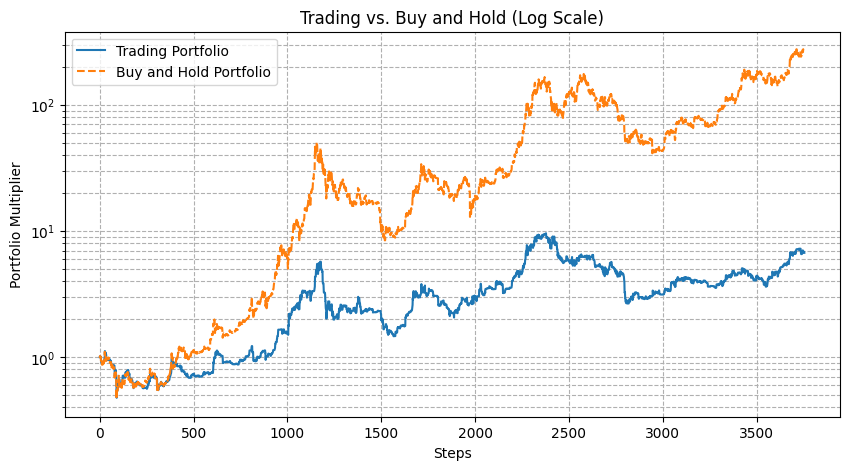

In [43]:
env = BitcoinTradingEnv()
obs = env.reset()
done = False

while not done:
    action = env.action_space.sample()  # Wähle zufällig eine Aktion (0, 1 oder 2)
    obs, reward, done, info = env.step(action)

env.plot_comparison_log()
